In [75]:
!pip install unidecode

In [76]:
!pip install googletrans==4.0.0-rc1

In [77]:
!pip install spacy

In [78]:
!pip install spacy_langdetect

In [79]:
!pip install pingouin

In [80]:
!pip install xgboost

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
np.random.seed(123454321)
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
from pingouin import pcorr

In [257]:
train = './train_products.json'
test = './test_products.json'

train = pd.read_json(train).T
test = pd.read_json(test).T

In [83]:
train.head()

,name,brand,generic_name,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,additives_count,calcium_100g,...,nutrition_grade,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation,ecoscore_grade
0,Pommes duchesse,"Pom lisse,Pom'Lisse, Marque Repère",unknown,"[en:frozen-foods, en:frozen-fried-potatoes, en...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:potato', 'percent': 82, 'percent_e...",1,unknown,...,b,[en:plastic],1,1.405794,0.122097,0.151978,0.400866,0.1234,0.344651,2
1,Bûche pâtissière à la crème au beurre,"Esprit de Fête,Carrefour",unknown,"[en:snacks, en:desserts, en:sweet-snacks, en:f...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:glucose-syrup', 'percent_estimate'...",10,unknown,...,e,"[en:cardboard, en:plastic]",1,1.772009,0,0.019531,0.288156,5.215055,0.171567,3
2,Cini Minis,"Nestlé, Nestlé",,"[en:plant-based-foods-and-beverages, en:plant-...",0,"[en:austria, en:france, en:germany, en:spain, ...",{'en:unknown': 100},"[{'id': 'en:whole-wheat-flour', 'percent': 37,...",3,0.635,...,d,"[en:paperboard, en:plastic]",1,2.2396,0,0.019531,0.281596,0.770511,0.252874,3
3,Cuor di fette Carrefour,Carrefour,unknown,"[en:dairies, en:fermented-foods, en:fermented-...",0,[en:italy],{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:chee...",2,unknown,...,e,[en:plastic],1,4.536405,0.006688,0.037393,0.185784,0.458632,0.217118,3
4,Curry,"Carrefour,Groupe Carrefour",unknown,"[en:plant-based-foods-and-beverages, en:plant-...",0,[en:france],{'en:unknown': 100},"[{'id': 'en:turmeric', 'percent_estimate': 55....",0,unknown,...,unknown,"[en:glass, en:plastic, en:unknown]",0,7.918371,0,0.015709,0.47839,0.445327,0.334988,4


In [84]:
train.columns

Index(['name', 'brand', 'generic_name', 'categories_hierarchy', 'is_beverage',
       'selling_countries', 'ingredient_origins', 'ingredients',
       'additives_count', 'calcium_100g', 'carbohydrates_100g',
       'energy_kcal_100g', 'fat_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'sugars_100g', 'nutrition_grade',
       'packaging_materials',
       'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'ecoscore_grade'],
      dtype='object')

In [85]:
train.shape

(20835, 28)

In [86]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20835 entries, 0 to 20834
Data columns (total 28 columns):
 #   Column                                                Non-Null Count  Dtype 
---  ------                                                --------------  ----- 
 0   name                                                  20835 non-null  object
 1   brand                                                 20835 non-null  object
 2   generic_name                                          20835 non-null  object
 3   categories_hierarchy                                  20835 non-null  object
 4   is_beverage                                           20835 non-null  object
 5   selling_countries                                     20835 non-null  object
 6   ingredient_origins                                    20835 non-null  object
 7   ingredients                                           20835 non-null  object
 8   additives_count                                       20835 non-nu

In [87]:
test.head()

,name,brand,generic_name,categories_hierarchy,is_beverage,selling_countries,ingredient_origins,ingredients,additives_count,calcium_100g,...,sugars_100g,nutrition_grade,packaging_materials,non_recyclable_and_non_biodegradable_materials_count,est_co2_agriculture,est_co2_consumption,est_co2_distribution,est_co2_packaging,est_co2_processing,est_co2_transportation
0,Activia saveur coco x 4,"Danone,Activia",unknown,"[en:dairies, en:fermented-foods, en:desserts, ...",0,"[en:belgium, en:france]","{'en:european-union': 50, 'en:france': 50}","[{'id': 'en:whole-milk', 'percent_estimate': '...",0,unknown,...,13.1,b,[en:plastic],1,0.86833498,0.0066875618,0.03557378,0.17703201,0.16833754,0.2016675
1,Danup peche melba,Danone,unknown,"[en:plant-based-foods-and-beverages, en:bevera...",1,[en:tunisia],{'en:unknown': 100},unknown,unknown,unknown,...,unknown,unknown,[en:unknown],1,0.091306974,0.0066875618,0.035436375,0.17779866,0.059533076,0.19037357
2,Off-the-charts cherry pie flavor not-so-tradit...,"Oikos,Danone",,"[en:dairies, en:fermented-foods, en:desserts, ...",0,"[en:france, en:united-states]",{'en:unknown': 100},"[{'has_sub_ingredients': 'yes', 'id': 'en:yogu...",1,0.067,...,10.67,b,[en:plastic],1,1.5302736,0.0066875618,0.03557378,0.18055336,0.14868799,0.23648173
3,Yaourt brassé nature,Danone,,"[en:dairies, en:fermented-foods, en:desserts, ...",0,[en:france],{'en:france': 100},"[{'id': 'en:whole-milk', 'origins': 'en:france...",0,0.149,...,5.7,b,[en:plastic],1,1.5453452,0.0066875618,0.03557378,0.18055336,0.15006915,0.20177885
4,Activia yaourt à boire myrtille,"Danone,Activia",unknown,"[en:beverages, en:dairies, en:fermented-foods,...",1,[en:poland],{'en:unknown': 100},"[{'id': 'en:skimmed-milk', 'percent_estimate':...",0,0.105,...,0.2,d,"[en:hdpe-high-density-polyethylene, en:ldpe-lo...",0,1.0464698,0.0066875618,0.037393191,0.18422242,0.16364051,0.2340023


In [88]:
test.columns

Index(['name', 'brand', 'generic_name', 'categories_hierarchy', 'is_beverage',
       'selling_countries', 'ingredient_origins', 'ingredients',
       'additives_count', 'calcium_100g', 'carbohydrates_100g',
       'energy_kcal_100g', 'fat_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'sugars_100g', 'nutrition_grade',
       'packaging_materials',
       'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation'],
      dtype='object')

In [89]:
def variance_correlation(df, var_umbral=0.2, corr_umbral=0.9):
    numeric = df.select_dtypes(include=[np.number])

    variances = numeric.var()

    threshold_variance = var_umbral
    low_variance_cols = variances[variances < threshold_variance].index.tolist()

    corr_matrix = numeric.corr()

    threshold_corr = corr_umbral
    corr_cols = set()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold_corr:
                colname = corr_matrix.columns[i]
                colnameb = corr_matrix.columns[j]
                corr_cols.add((colname, colnameb))

    print("Columns with low variance:", low_variance_cols)
    print("Redundant or highly correlated columns:", len(corr_cols),list(corr_cols))

    return corr_cols

In [90]:
def partial_corr(df, corr_umbral=0.9):
    numeric = df.select_dtypes(include=[np.number])

    partial_corr_matrix = numeric.pcorr()

    threshold = corr_umbral

    high_partial_corr = []
    corr_list = []

    for i in range(len(partial_corr_matrix.columns)):
        for j in range(i):
            if abs(partial_corr_matrix.iloc[i, j]) > threshold:
                colname_i = partial_corr_matrix.columns[i]
                colname_j = partial_corr_matrix.columns[j]
                high_partial_corr.append((colname_i, colname_j, partial_corr_matrix.iloc[i, j]))
                corr_list.append((colname_i, colname_j))

    for pair in high_partial_corr:
        print(f"Columns: {pair[0]}, {pair[1]}, Partial Correlation: {pair[2]}")

    return corr_list

In [91]:
def target_corr(df, variable, umbral=0.85):

    numeric = df.select_dtypes(include=[np.number])

    target_variable = variable

    correlation_matrix = numeric.corr()
    target_correlation = correlation_matrix[target_variable]

    high_corr_variables = target_correlation[abs(target_correlation) >= umbral].index.tolist()

    print("Variables highly correlated with the target variable:", high_corr_variables)

    return high_corr_variables

In [92]:
def corr_matrix(df):
    numeric = df.select_dtypes(include=[np.number])

    corr_matrix = numeric.corr()

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.clustermap(corr_matrix, mask=mask, cmap=cmap)

    plt.show()

# Data Transformation


In [93]:
df = train.copy()
df['selling_countries'] = df['selling_countries'].apply(lambda d: d if isinstance(d, list) else [])

df_exploded = df.explode('selling_countries')

df_encoded = pd.get_dummies(df_exploded, columns=['selling_countries'], prefix='', prefix_sep='')

df_final = df_encoded.groupby(level=0).sum()

C:\Users\santi\AppData\Local\Temp\ipykernel_10956\2715528715.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_final = df_encoded.groupby(level=0).sum()


In [94]:
def get_country_name(country_code):
    country = country_code.split(":", 1)[1]
    return country if country else None

df['selling_countries'] = df['selling_countries'].apply(lambda countries: [get_country_name(country) for country in countries])

df_exploded = df.explode('selling_countries')
df_encoded = pd.get_dummies(df_exploded, columns=['selling_countries'], prefix='', prefix_sep='')
df_final = df_encoded.groupby(level=0).sum()

C:\Users\santi\AppData\Local\Temp\ipykernel_10956\2538216379.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_final = df_encoded.groupby(level=0).sum()


In [95]:
len(df_final.columns)

167

In [96]:
from googletrans import Translator

translator = Translator()

countries = list(df_final.columns)

translated_countries = [translator.translate(country, dest='en').text for country in countries]

In [97]:
translated_countries = list(map(lambda x: x.lower(), translated_countries))

In [98]:
len(translated_countries)

167

# We now manually select the countries that were not correctly translated

In [99]:
country_correct = {'belgica':'belgium', 'usa':'united states', 'franca':'france',
                   'deutschland':'germany', 'guadalupe':'guadeloupe',
                   'the netherlands':'netherlands', 'dutchman':'netherlands', 'polynesia-french':'french-polynesia',
                    'swiss': 'switzerland', 'united-states':'united states', 'united-kingdom':'united kingdom'}

In [100]:
corrected_countries = [country_correct.get(country, country) for country in translated_countries]

In [101]:
len(corrected_countries)

167

In [102]:
df_final.columns = corrected_countries

In [103]:
df_final

,afghanistan,aland-islands,albania,germany,algeria,andorra,andorra-france-espana,angola,argentina,australia,...,germany,ukraine,united-arab-emirates,united kingdom,united states,uruguay,uzbekistan,venezuela,yugoslavia,serbia
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
dup_cols_dict = {}

for correct in corrected_countries:
    if correct not in dup_cols_dict:
        dup_cols_dict[correct] = [correct]
    else:
        dup_cols_dict[correct].append(correct)

duplicate_cols = list(dup_cols_dict.values())

In [105]:
duplicate_cols

[['afghanistan'],
 ['aland-islands'],
 ['albania'],
 ['germany', 'germany', 'germany', 'germany', 'germany'],
 ['algeria'],
 ['andorra'],
 ['andorra-france-espana'],
 ['angola'],
 ['argentina'],
 ['australia'],
 ['austria', 'austria'],
 ['bahrain'],
 ['bangladesh'],
 ['belarus'],
 ['belgium', 'belgium', 'belgium', 'belgium', 'belgium', 'belgium'],
 ['bolivia'],
 ['bosnia-and-herzegovina'],
 ['brazil'],
 ['bulgaria'],
 ['burkina faso'],
 ['cameroon'],
 ['canada'],
 ['chile'],
 ['china'],
 ['colombia'],
 ['costa rica'],
 ['ivory coast'],
 ['croatia'],
 ['czech-republic'],
 ['denmark'],
 ['dominican-republic'],
 ['east-germany'],
 ['ecuador'],
 ['egypt'],
 ['in'],
 ['spain', 'spain', 'spain', 'spain', 'spain', 'spain'],
 ['united states', 'united states', 'united states'],
 ['estonia'],
 ['ethiopia'],
 ['european-union'],
 ['finland'],
 ['france', 'france', 'france', 'france', 'france', 'france', 'france'],
 ['french-guiana'],
 ['french-polynesia', 'french-polynesia'],
 ['gabon'],
 ['ghan

In [106]:
for cols in duplicate_cols:
    combined_name = cols[0]
    df_final[combined_name] = df_final[cols].max(axis=1)
    df_final = df_final.drop(columns=cols[1:])

In [107]:
df_final.shape

(20835, 106)

In [108]:
df_final

,afghanistan,aland-islands,albania,algeria,andorra,andorra-france-espana,angola,argentina,australia,bahrain,...,togo,trinidad-and-tobago,tunisia,turkey,ukraine,united-arab-emirates,uruguay,uzbekistan,venezuela,yugoslavia
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
list(train.columns)

['name',
 'brand',
 'generic_name',
 'categories_hierarchy',
 'is_beverage',
 'selling_countries',
 'ingredient_origins',
 'ingredients',
 'additives_count',
 'calcium_100g',
 'carbohydrates_100g',
 'energy_kcal_100g',
 'fat_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'sugars_100g',
 'nutrition_grade',
 'packaging_materials',
 'non_recyclable_and_non_biodegradable_materials_count',
 'est_co2_agriculture',
 'est_co2_consumption',
 'est_co2_distribution',
 'est_co2_packaging',
 'est_co2_processing',
 'est_co2_transportation',
 'ecoscore_grade']

In [110]:
train.shape

(20835, 28)

# Drop unknowns

In [111]:
train = train.replace('unknown', np.nan)

In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20835 entries, 0 to 20834
Data columns (total 28 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   name                                                  20507 non-null  object 
 1   brand                                                 20835 non-null  object 
 2   generic_name                                          2211 non-null   object 
 3   categories_hierarchy                                  20835 non-null  object 
 4   is_beverage                                           20835 non-null  int64  
 5   selling_countries                                     20832 non-null  object 
 6   ingredient_origins                                    20835 non-null  object 
 7   ingredients                                           15681 non-null  object 
 8   additives_count                                       15

In [113]:
train.drop(['calcium_100g','generic_name'], axis=1, inplace=True)

additives_count


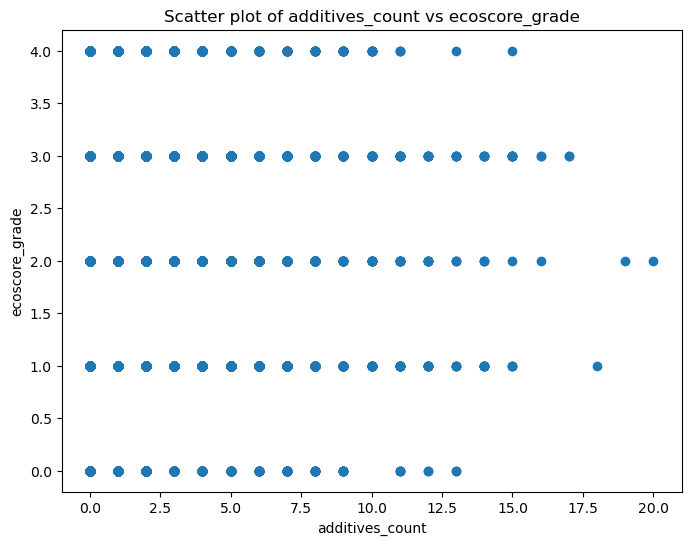

Correlation between additives_count and ecoscore_grade: -0.011289753382120843
carbohydrates_100g


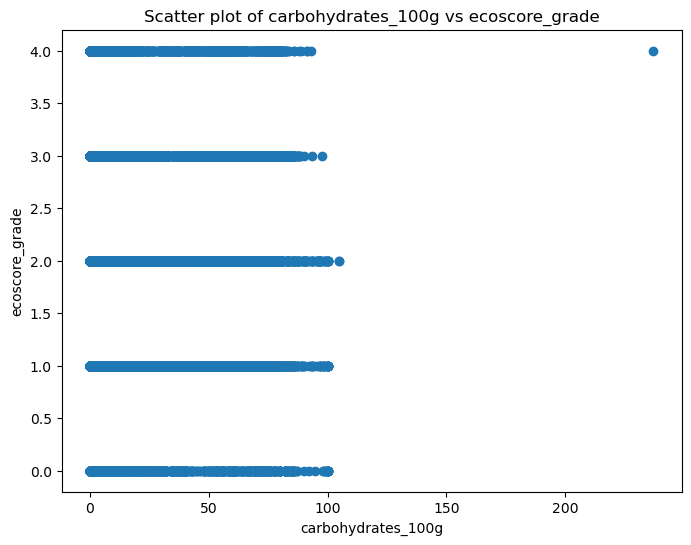

Correlation between carbohydrates_100g and ecoscore_grade: -0.07141582583748121
energy_kcal_100g


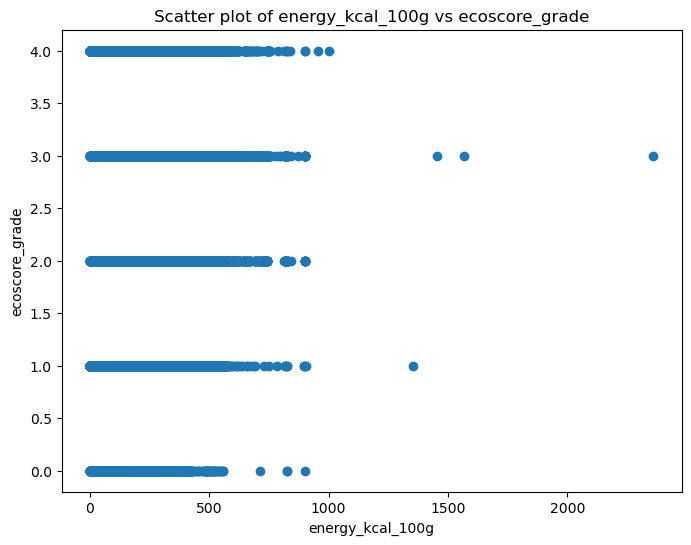

Correlation between energy_kcal_100g and ecoscore_grade: 0.23171607231798239
fat_100g


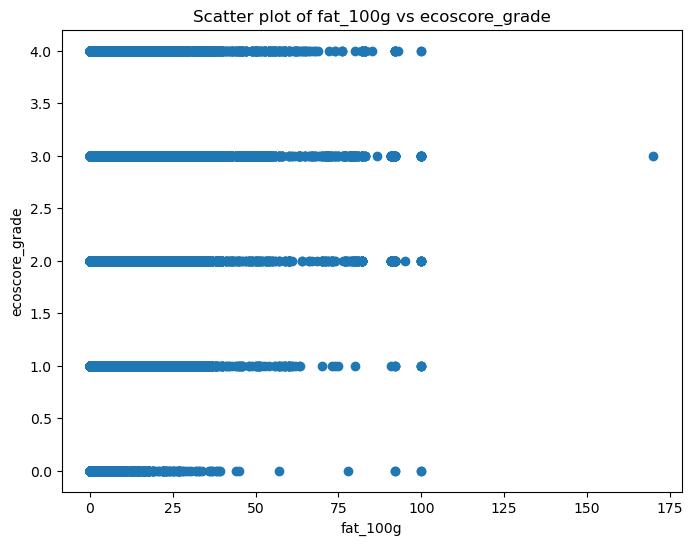

Correlation between fat_100g and ecoscore_grade: 0.2533976491938555
fiber_100g


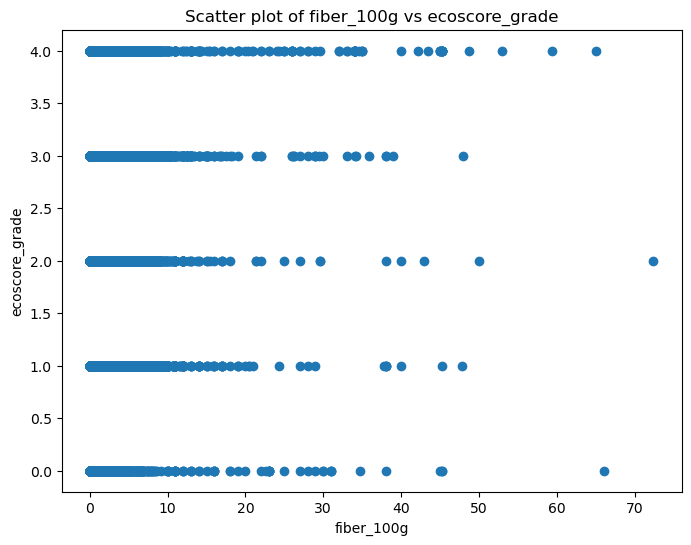

Correlation between fiber_100g and ecoscore_grade: 0.053133667785662385
proteins_100g


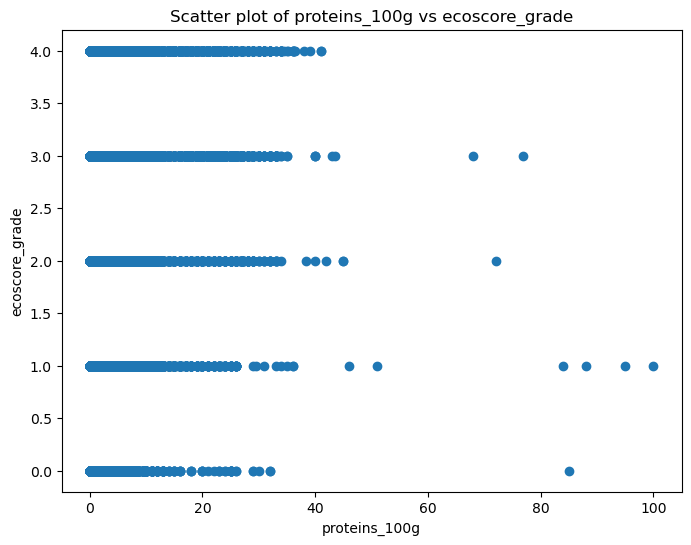

Correlation between proteins_100g and ecoscore_grade: 0.3996851860114386
salt_100g


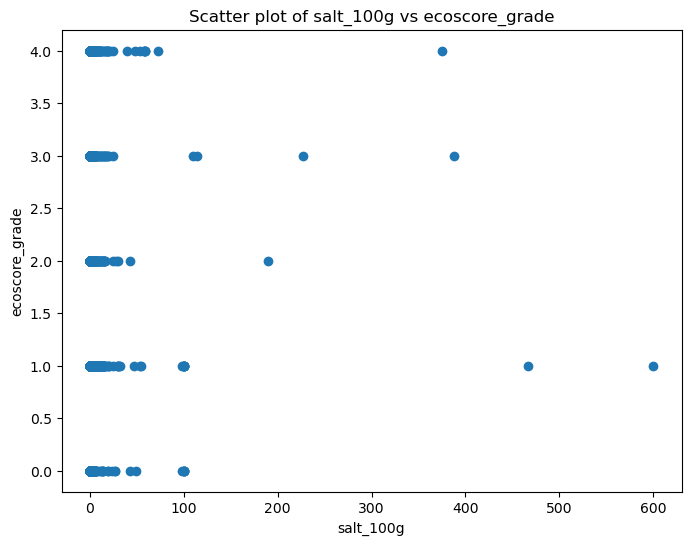

Correlation between salt_100g and ecoscore_grade: 0.01814738569515333
sodium_100g


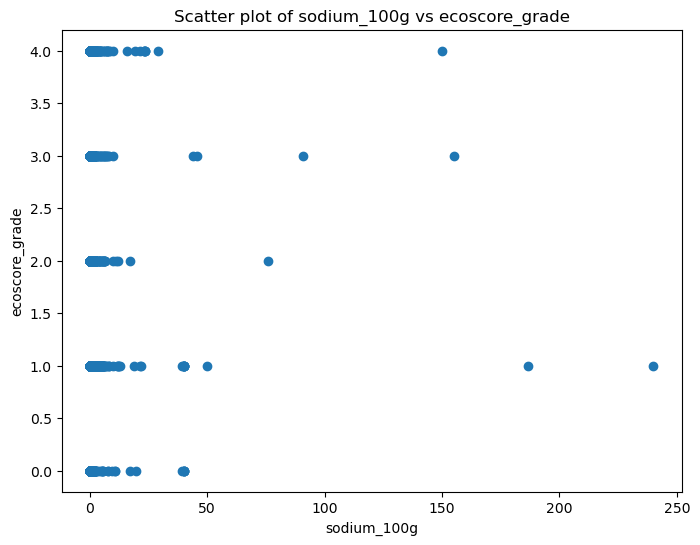

Correlation between sodium_100g and ecoscore_grade: 0.017267335437473004
sugars_100g


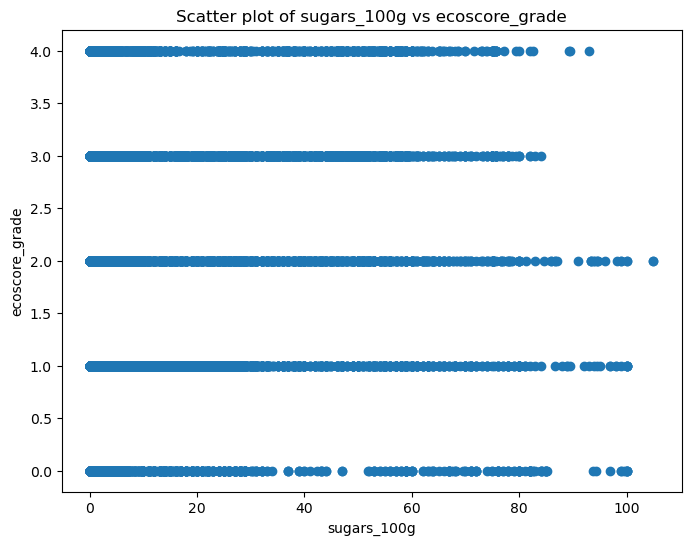

Correlation between sugars_100g and ecoscore_grade: -0.00405444996267588


In [114]:
import matplotlib.pyplot as plt

cols_list = ['additives_count', 'carbohydrates_100g', 'energy_kcal_100g',
             'fat_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g']

correlation_list = []

for col in cols_list:
    print(col)
    if col in train.columns:
        plt.figure(figsize=(8,6))
        train[col] = pd.to_numeric(train[col], errors='coerce')
        plt.scatter(train[col], train['ecoscore_grade'])
        plt.xlabel(col)
        plt.ylabel('ecoscore_grade')
        plt.title(f'Scatter plot of {col} vs ecoscore_grade')
        plt.show()

        corr = train[col].corr(train['ecoscore_grade']) # calculating the correlation
        correlation_list.append((col, corr)) # appending the correlation to the list
        print(f'Correlation between {col} and ecoscore_grade: {corr}')

    else:
        print(f"{col} doesn't exist in the DataFrame.")

In [115]:
train.drop('nutrition_grade', axis=1, inplace=True)

In [116]:
train.drop('ingredients', axis=1, inplace=True)

In [117]:
train.shape

(20835, 24)

In [118]:
# why would name tell us anything?
train.drop('name', axis=1, inplace=True)

In [119]:
train.drop('ingredient_origins', axis=1, inplace=True)

In [120]:
train.drop('selling_countries', axis=1, inplace=True)

In [121]:
train.packaging_materials

0                              [en:plastic]
1                [en:cardboard, en:plastic]
2               [en:paperboard, en:plastic]
3                              [en:plastic]
4        [en:glass, en:plastic, en:unknown]
                        ...                
20830                          [en:unknown]
20831                          [en:unknown]
20832                          [en:unknown]
20833                          [en:plastic]
20834                          [en:unknown]
Name: packaging_materials, Length: 20835, dtype: object

In [122]:
import pandas as pd

df_new = train['packaging_materials'].apply(pd.Series)

df_new = df_new.applymap(lambda x: x.replace('en:', '') if pd.notnull(x) else '')

df_long = df_new.melt(ignore_index=False)

df_long = df_long.dropna()

df_packaging = pd.get_dummies(df_long, columns=['value']).groupby(level=0).sum()

df_packaging = df_packaging.clip(upper=1)

df_packaging.head()

,variable,value_,value_22,value_40,value_90,value_baking-paper,value_brown-glass,value_cardboard,value_clear-glass,value_composite-material,...,value_xx:81-c-ldpe,value_xx:81-c-opp,value_xx:81-c-pap,value_xx:81-c-pet,value_xx:81-c-petmet,value_xx:82-c-pap,value_xx:84-c-pap,value_xx:90-c-ldpe,value_xx:90-c-pp,value_xx:91-c-fe
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [123]:
df_packaging.columns = df_packaging.columns.str.replace('value_', '', regex=False)

In [124]:
df_packaging.drop('unknown', axis=1, inplace=True)

In [125]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20835 entries, 0 to 20834
Data columns (total 21 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   brand                                                 20835 non-null  object 
 1   categories_hierarchy                                  20835 non-null  object 
 2   is_beverage                                           20835 non-null  int64  
 3   additives_count                                       15681 non-null  float64
 4   carbohydrates_100g                                    18558 non-null  float64
 5   energy_kcal_100g                                      15993 non-null  float64
 6   fat_100g                                              18500 non-null  float64
 7   fiber_100g                                            13313 non-null  float64
 8   proteins_100g                                         18

In [126]:
train.categories_hierarchy

0        [en:frozen-foods, en:frozen-fried-potatoes, en...
1        [en:snacks, en:desserts, en:sweet-snacks, en:f...
2        [en:plant-based-foods-and-beverages, en:plant-...
3        [en:dairies, en:fermented-foods, en:fermented-...
4        [en:plant-based-foods-and-beverages, en:plant-...
                               ...                        
20830    [en:plant-based-foods-and-beverages, en:bevera...
20831    [en:plant-based-foods-and-beverages, en:bevera...
20832    [en:snacks, en:sweet-snacks, en:cocoa-and-its-...
20833    [en:dairies, en:fats, en:spreads, en:spreadabl...
20834    [en:meats-and-their-products, en:meats, en:pou...
Name: categories_hierarchy, Length: 20835, dtype: object

In [127]:
train['first_category'] = train['categories_hierarchy'].apply(lambda x: x[0].replace('en:', '') if x else None)

df_cat = pd.get_dummies(train['first_category'])
df_cat = df_cat.clip(upper=1)

df_cat

,baby-foods,beverages,breakfasts,canned-foods,chips-and-fries,cocoa-and-its-products,condiments,crepes-and-galettes,dairies,desserts,...,meals,meat-alternatives,meats-and-their-products,plant-based-foods-and-beverages,sandwiches,seafood,snacks,spreads,sweet-pies,sweeteners
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
20831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
20832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
20833,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
df_brand = pd.get_dummies(train['brand'])
df_brand = df_brand.clip(upper=1)

df_brand

,? (Carrefour),"AGIR,Carrefour","ALESTO,Carrefour","Ades,Unilever","Adrien Champaud, Marque Repère","After Eight,Nestlé","Algida,Unilever","Alpen Gold,Mondelez","Alpen Gold,Mondelez,Alpen Gold Max Fun","Alpen Gold,Nussbeisser,Mondelez",...,"เนสกาแฟ,Nescafe,Nestle,เนสเล่","เนสกาแฟ,Nescafe,เนสเล่,Nestle","เนสกาแฟ,เนสเล่,Nescafe,Nestle","เนสเล่, Nestle","เนสเล่,Nestle","แม็กกี้,Maggi,Nestle,เนสเล่","โกโก้ครั้นช์,koko krunch,kokokrunch,เนสเล่,Nestle","โดริโทส,doritos,PepsiCo","โอริโอ,โอริโอ้,oreo,เนสเล่,Nestle","ネスレ,Nestlé"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
big_string = (' ').join(list(df_brand.columns)).replace(',', ' ').lower()

In [130]:
big_string

"? (carrefour) agir carrefour alesto carrefour ades unilever adrien champaud  marque repère after eight nestlé algida unilever alpen gold mondelez alpen gold mondelez alpen gold max fun alpen gold nussbeisser mondelez alsa  unilever alsa unilever altis unilever alvalle pepsico alvalle pepsico amino unilever amora  unilever amora unilever amora unilever  unilever food solutions amora unilever calvé amora unilever mayonnise de dijon antoine barrier  marque repère asia knorr unilever astoria  carrefour auchan  carrefour auguste mugniot  marque repère auguste mugniot marque repère autour du dessert marque repère babybio carrefour benenuts pepsico  3d's bugles  lays benenuts pepsico twinuts bio village marque repère bio village marque repère bio village marque repère scamark (filiale e. leclerc) boci nestlé bon app' carrefour bon app' carrefour baird's  marque repère balaton nestlé bassetts mondelez beauchais  marque repère  chantet blanet becel  unilever becel unilever belvita lu mondelez 

In [131]:
from unidecode import unidecode
import re

clean_string = re.sub(r'\W+', ' ', big_string)

clean_string = re.sub(r'\s+', ' ', clean_string).strip()

In [132]:
from collections import Counter

words = clean_string.split()

word_counts = Counter(words)

most_common_words = word_counts.most_common(200)

In [133]:
word_counts

Counter({'carrefour': 566,
         'agir': 2,
         'alesto': 1,
         'ades': 1,
         'unilever': 246,
         'adrien': 2,
         'champaud': 2,
         'marque': 583,
         'repère': 548,
         'after': 4,
         'eight': 4,
         'nestlé': 653,
         'algida': 7,
         'alpen': 4,
         'gold': 5,
         'mondelez': 240,
         'max': 2,
         'fun': 1,
         'nussbeisser': 2,
         'alsa': 3,
         'altis': 1,
         'alvalle': 2,
         'pepsico': 92,
         'amino': 2,
         'amora': 6,
         'food': 6,
         'solutions': 4,
         'calvé': 5,
         'mayonnise': 1,
         'de': 78,
         'dijon': 1,
         'antoine': 2,
         'barrier': 2,
         'asia': 2,
         'knorr': 16,
         'astoria': 1,
         'auchan': 1,
         'auguste': 4,
         'mugniot': 4,
         'autour': 5,
         'du': 46,
         'dessert': 32,
         'babybio': 1,
         'benenuts': 5,
         '3d': 9,
 

In [134]:
import re

def preprocess(column_name):
    column_name = re.sub(r'\W+', ' ', column_name)  # replace non-alphanumeric characters with spaces
    column_name = re.sub(r'\s+', ' ', column_name).strip()  # replace multiple spaces with a single space, then strip leading/trailing spaces
    column_name = column_name.lower()  # convert to lowercase
    return [word for word in column_name.split() if word.isalpha()]  # split into words and return a list of words, excluding numbers

def rename_columns(col_name):
    words_in_col_name = preprocess(col_name)
    for word in words_in_col_name:
        if word in word_counts.keys() and len(word) > 2:
            return word
    return col_name  # return original column name if no match

# Apply the function to each column name
df_brand.columns = [rename_columns(col) for col in df_brand.columns]

In [135]:
list(df_brand.columns.unique().sort_values())

['ades',
 'adrien',
 'after',
 'agir',
 'alesto',
 'algida',
 'alpen',
 'alsa',
 'altis',
 'alvalle',
 'amino',
 'amora',
 'antoine',
 'asia',
 'astoria',
 'auchan',
 'auguste',
 'autour',
 'baby',
 'babybio',
 'baird',
 'balaton',
 'barral',
 'bassetts',
 'beauchais',
 'becel',
 'belin',
 'beltè',
 'belvita',
 'belvitalu',
 'ben',
 'benenuts',
 'bertolli',
 'best',
 'bio',
 'birds',
 'biscoff',
 'boci',
 'boliane',
 'bon',
 'bonapp',
 'bono',
 'boss',
 'boy',
 'breyers',
 'brin',
 'britley',
 'brun',
 'bugles',
 'buitoni',
 'bénenuts',
 'bénédicta',
 'bénénuts',
 'cadbury',
 'cailler',
 'calvé',
 'carambar',
 'carrefour',
 'carrefourcarefour',
 'carte',
 'casa',
 'centroproizvod',
 'cerealitas',
 'chamonix',
 'champs',
 'chantegril',
 'chantet',
 'chaque',
 'charge',
 'charleval',
 'cheerios',
 'cheetos',
 'chez',
 'chipsy',
 'chocapic',
 'christie',
 'clavel',
 'club',
 'clusters',
 'collection',
 'colman',
 'comptoir',
 'confiseo',
 'confiserie',
 'confiséo',
 'conimex',
 'continent

In [136]:
correct = {'belvitalu':'belvita', 'bénénuts':'bénenuts',
           'carrefourcarefour':'carrefour','confiséo':'confiseo', 'coté':'cote',
          'côte':'cote', 'côté':'cote','cöté':'cote','délisse':'delisse','eléphant':'elephant','extrême':'extreme',
          'filière':'filiere', 'hellmann':'hellman', 'hellmans':'hellman','lay':'lays','maraboumondelez':'marabou',
          'marque':'marquet', 'milkamondelez':'milka','mondelèz':'mondelez','mondeléz':'mondelez','mondelēz':'mondelez',
          'nescafé':'nescafe','nesquick':'nesquik', 'nestlè':'nestle', 'nestlé':'nestle','néstlé':'nestle', 'opava':'opavia',
          'oreo':'oreos', 'oreo':'oréo', 'pepsico':'pepsi','reflet':'reflets', 'simplu':'simpl','spécial':'special','thomi':'thomy',
          'volandrie':'volandry', 'élephant':'elephant','éléphant':'elephant'}

In [137]:
corrected_brands = [correct.get(country, country) for country in df_brand.columns]
df_brand.columns = corrected_brands

In [138]:
df_brand.columns.value_counts()

nestle          340
carrefour       216
marquet         164
mondelez         57
unilever         37
               ... 
laboratoires      1
table             1
napolitain        1
mondélez          1
ネスレ               1
Length: 457, dtype: int64

# Done with the categorical variables... On to the numerical ones

In [139]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20835 entries, 0 to 20834
Data columns (total 22 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   brand                                                 20835 non-null  object 
 1   categories_hierarchy                                  20835 non-null  object 
 2   is_beverage                                           20835 non-null  int64  
 3   additives_count                                       15681 non-null  float64
 4   carbohydrates_100g                                    18558 non-null  float64
 5   energy_kcal_100g                                      15993 non-null  float64
 6   fat_100g                                              18500 non-null  float64
 7   fiber_100g                                            13313 non-null  float64
 8   proteins_100g                                         18

In [140]:
train.columns

Index(['brand', 'categories_hierarchy', 'is_beverage', 'additives_count',
       'carbohydrates_100g', 'energy_kcal_100g', 'fat_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g',
       'packaging_materials',
       'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'ecoscore_grade', 'first_category'],
      dtype='object')

In [143]:
train[numeric] = train[numeric].astype(float)

In [144]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20835 entries, 0 to 20834
Data columns (total 22 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   brand                                                 20835 non-null  object 
 1   categories_hierarchy                                  20835 non-null  object 
 2   is_beverage                                           20835 non-null  float64
 3   additives_count                                       15681 non-null  float64
 4   carbohydrates_100g                                    18558 non-null  float64
 5   energy_kcal_100g                                      15993 non-null  float64
 6   fat_100g                                              18500 non-null  float64
 7   fiber_100g                                            13313 non-null  float64
 8   proteins_100g                                         18

In [145]:
variance_correlation(train, var_umbral=0.1, corr_umbral=0.8)

Columns with low variance: ['est_co2_consumption', 'est_co2_distribution', 'est_co2_transportation']
Redundant or highly correlated columns: 1 [('sodium_100g', 'salt_100g')]


{('sodium_100g', 'salt_100g')}

In [146]:
partial_corr(train, corr_umbral=0.8)

Columns: energy_kcal_100g, carbohydrates_100g, Partial Correlation: 0.8378843664812617
Columns: fat_100g, carbohydrates_100g, Partial Correlation: -0.8232572279092976
Columns: fat_100g, energy_kcal_100g, Partial Correlation: 0.9528068502811975
Columns: sodium_100g, salt_100g, Partial Correlation: 0.993346670661728


[('energy_kcal_100g', 'carbohydrates_100g'),
 ('fat_100g', 'carbohydrates_100g'),
 ('fat_100g', 'energy_kcal_100g'),
 ('sodium_100g', 'salt_100g')]

In [147]:
# After seeing the partial correlations, we'll drop sal and energy_kcal_100g because this one has to little data
train.drop(['salt_100g', 'energy_kcal_100g'], axis=1, inplace=True)

In [148]:
target_corr(train, 'ecoscore_grade', umbral=0.2)

Variables highly correlated with the target variable: ['fat_100g', 'proteins_100g', 'non_recyclable_and_non_biodegradable_materials_count', 'est_co2_agriculture', 'est_co2_processing', 'est_co2_transportation', 'ecoscore_grade']


['fat_100g',
 'proteins_100g',
 'non_recyclable_and_non_biodegradable_materials_count',
 'est_co2_agriculture',
 'est_co2_processing',
 'est_co2_transportation',
 'ecoscore_grade']

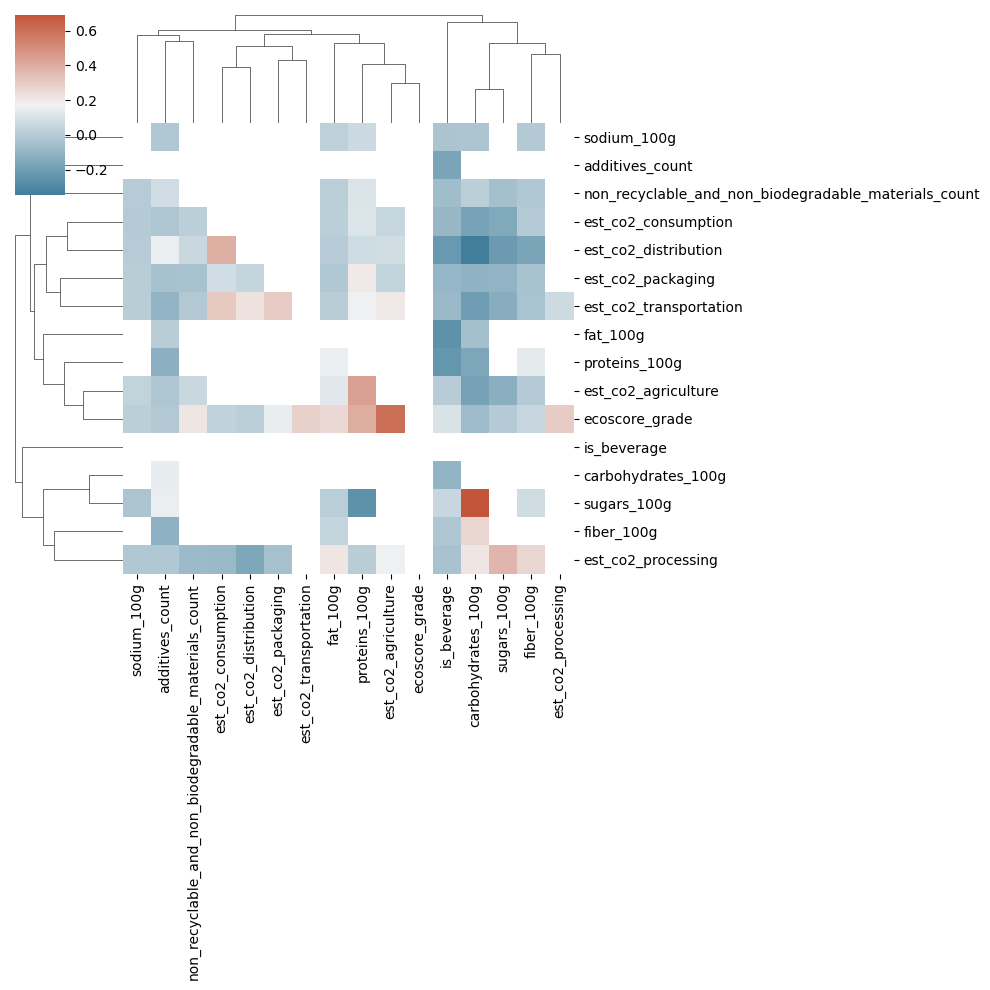

In [149]:
corr_matrix(train)

In [150]:
numeric = ['is_beverage','additives_count',
       'carbohydrates_100g', 'fat_100g', 'fiber_100g',
       'proteins_100g', 'sodium_100g', 'sugars_100g',
       'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation',
       'ecoscore_grade']

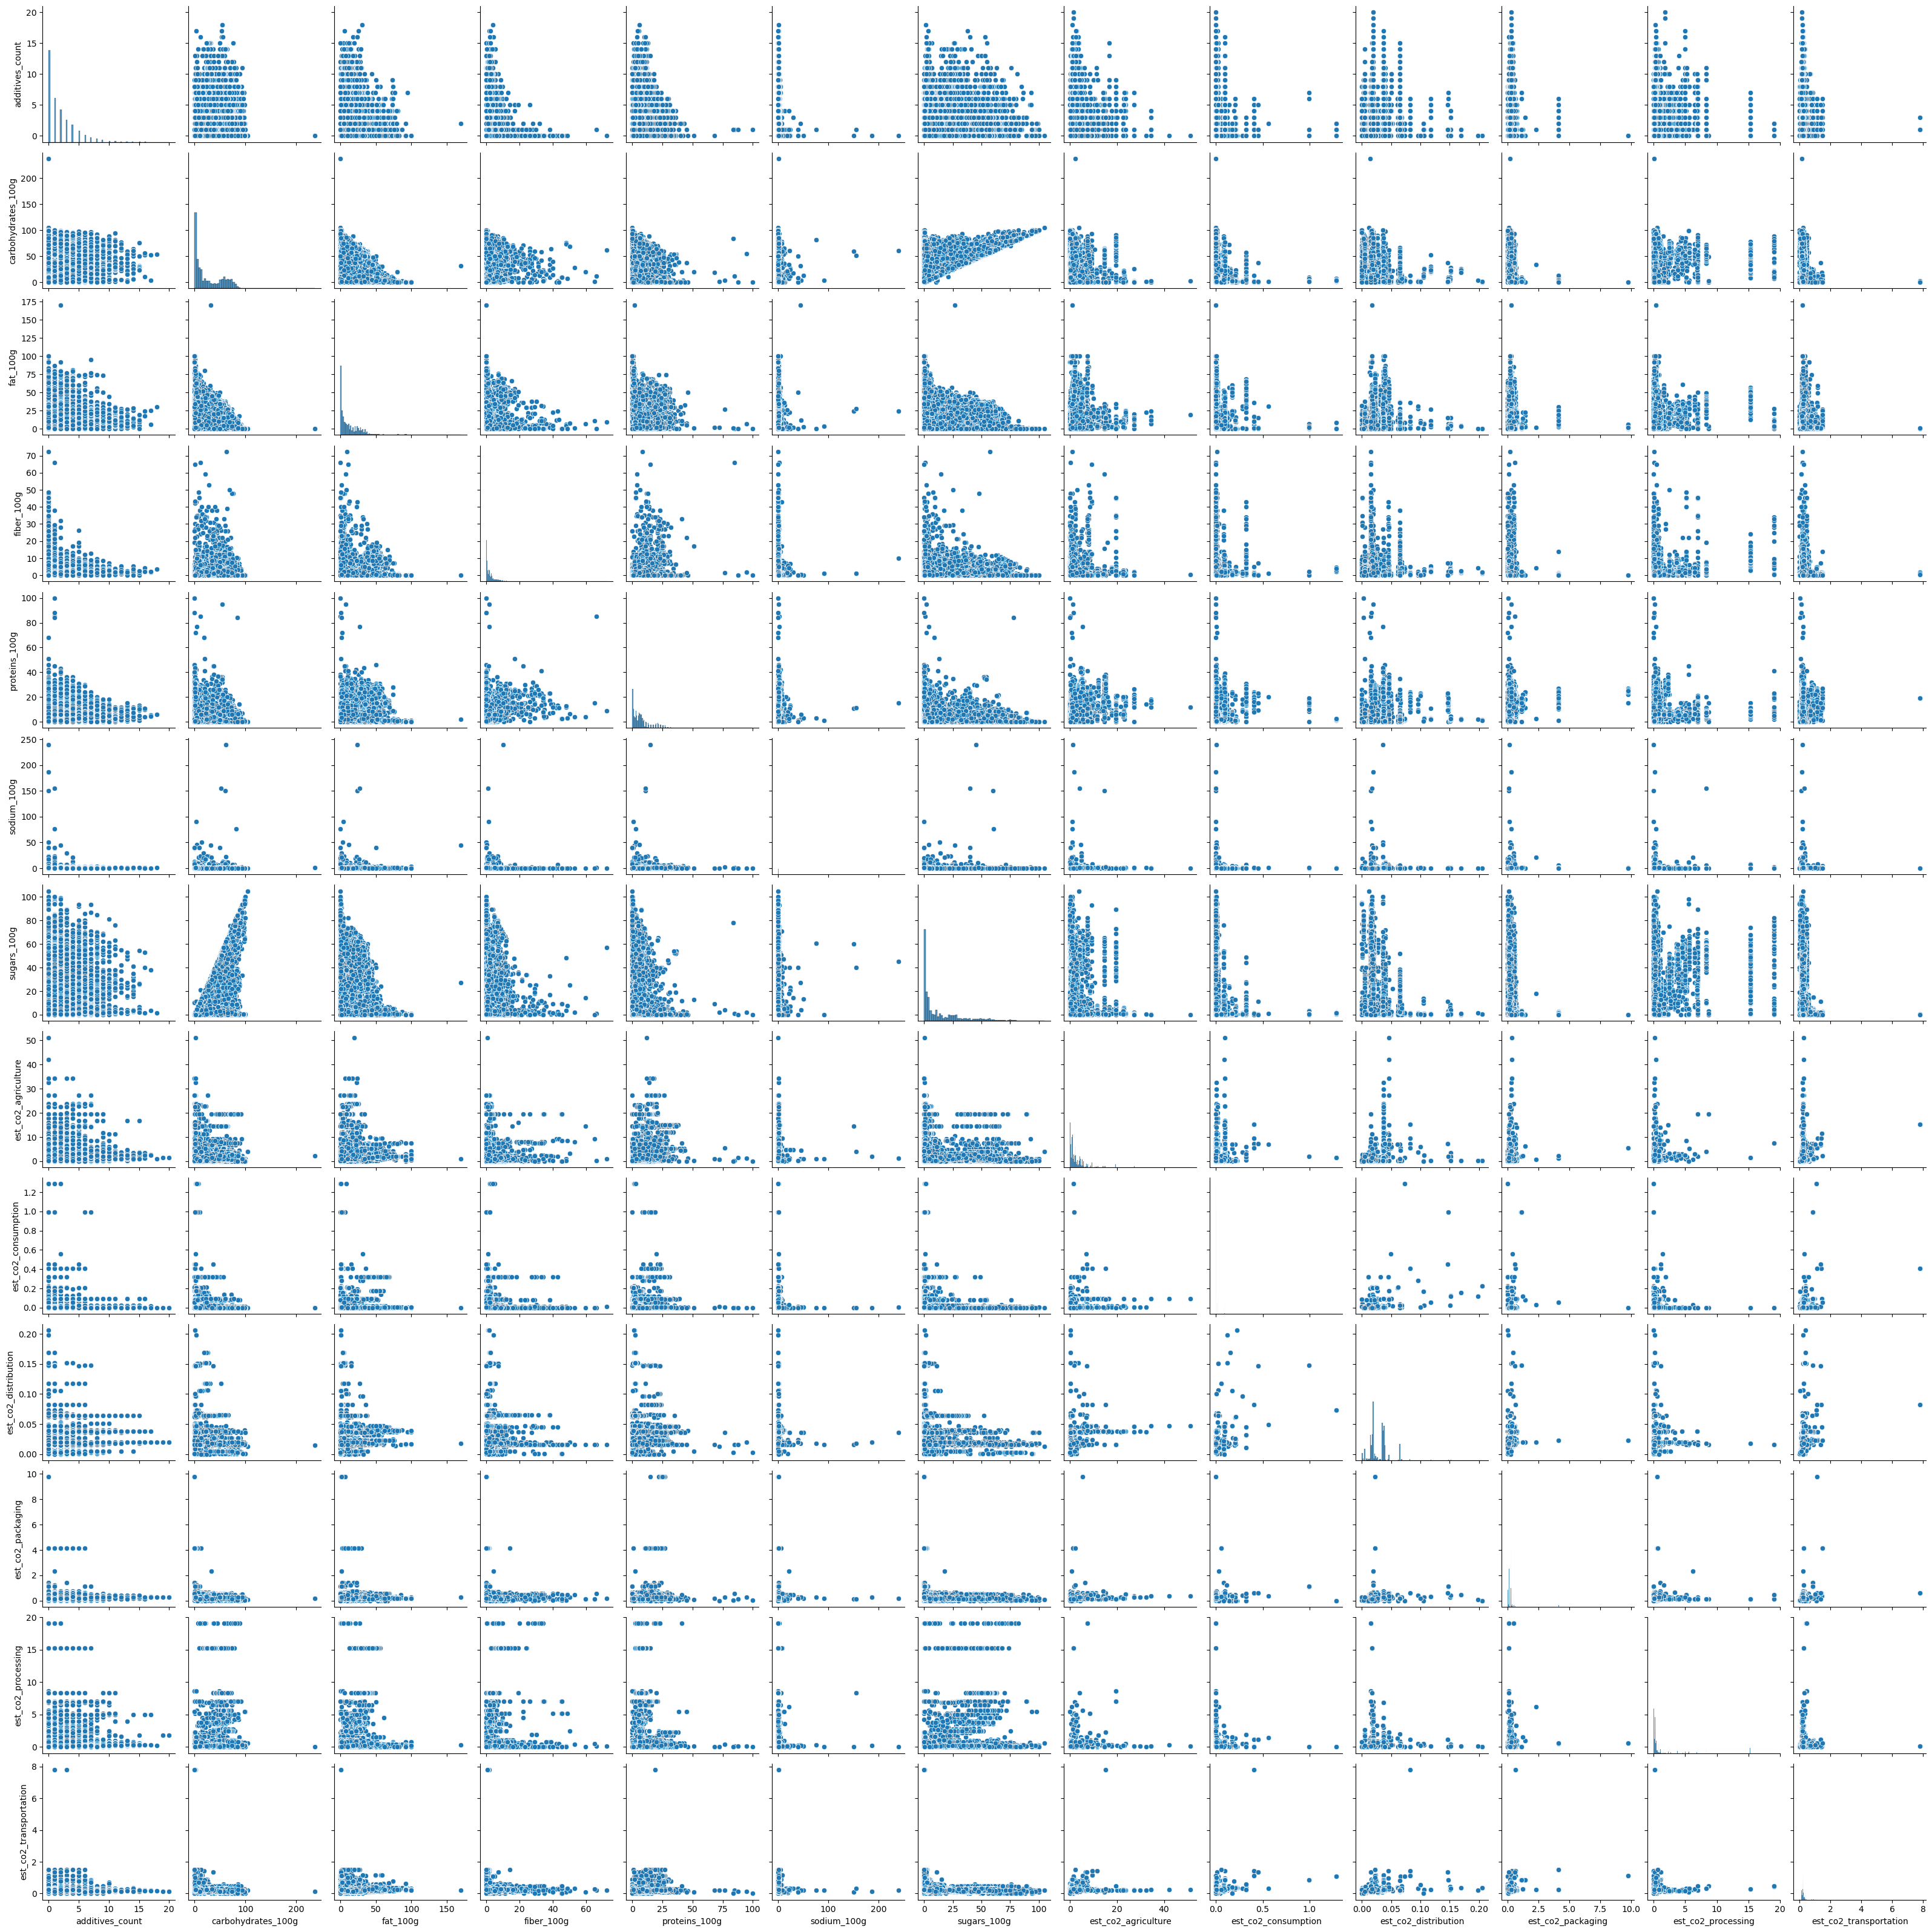

In [151]:
sns.pairplot(train[numeric].drop(['is_beverage', 'non_recyclable_and_non_biodegradable_materials_count', 'ecoscore_grade'], axis=1))
plt.show()

In [152]:
train.dropna(inplace=True)

In [153]:
train = pd.concat([train, df_final, df_cat, df_brand,df_packaging], axis=1)

In [154]:
train.drop(['brand','categories_hierarchy',
            'packaging_materials','first_category'], axis=1, inplace=True)

In [155]:
train.shape

(20835, 2384)

In [199]:
# First, applying the same cleaning to test data:
def clean_data(test):
    df = test.copy()

    df['selling_countries'] = df['selling_countries'].apply(lambda d: d if isinstance(d, list) else [])

    df_exploded = df.explode('selling_countries')

    df_encoded = pd.get_dummies(df_exploded, columns=['selling_countries'], prefix='', prefix_sep='')

    df_final = df_encoded.groupby(level=0).sum()

    df['selling_countries'] = df['selling_countries'].apply(lambda countries: [get_country_name(country) for country in countries])

    df_exploded = df.explode('selling_countries')
    df_encoded = pd.get_dummies(df_exploded, columns=['selling_countries'], prefix='', prefix_sep='')
    df_final = df_encoded.groupby(level=0).sum()

    translator = Translator()

    countries = list(df_final.columns)
    
    translated_countries = [translator.translate(country, dest='en').text for country in countries]

    translated_countries = list(map(lambda x: x.lower(), translated_countries))

    country_correct = {'belgica':'belgium', 'usa':'united states', 'franca':'france',
                   'deutschland':'germany', 'guadalupe':'guadeloupe',
                   'the netherlands':'netherlands', 'dutchman':'netherlands', 'polynesia-french':'french-polynesia',
                    'swiss': 'switzerland', 'united-states':'united states', 'united-kingdom':'united kingdom'}

    corrected_countries = [country_correct.get(country, country) for country in translated_countries]

    df_final.columns = corrected_countries

    dup_cols_dict = {}

    for correct in corrected_countries:
        if correct not in dup_cols_dict:
            dup_cols_dict[correct] = [correct]
        else:
            dup_cols_dict[correct].append(correct)

    duplicate_cols = list(dup_cols_dict.values())

    for cols in duplicate_cols:
      combined_name = cols[0]
      df_final[combined_name] = df_final[cols].max(axis=1)
      df_final = df_final.drop(columns=cols[1:])

    test = test.replace('unknown', 0)

    test.drop(['calcium_100g','generic_name',
               'nutrition_grade', 'ingredients', 'name', 'selling_countries',
               'salt_100g', 'energy_kcal_100g'], axis=1, inplace=True)

    df_new = test['packaging_materials'].apply(pd.Series)

    df_new = df_new.applymap(lambda x: x.replace('en:', '') if pd.notnull(x) else '')

    df_long = df_new.melt(ignore_index=False)

    df_packaging = pd.get_dummies(df_long, columns=['value']).groupby(level=0).sum()

    df_packaging = df_packaging.clip(upper=1)

    df_packaging.columns = df_packaging.columns.str.replace('value_', '', regex=False)

    df_packaging.drop('unknown', axis=1, inplace=True)

    test['first_category'] = test['categories_hierarchy'].apply(lambda x: x[0].replace('en:', '') if x else None)

    df_cat = pd.get_dummies(test['first_category'])
    df_cat = df_cat.clip(upper=1)

    df_brand = pd.get_dummies(test['brand'])
    df_brand = df_brand.clip(upper=1)

    big_string = (' ').join(list(df_brand.columns)).replace(',', ' ').lower()

    clean_string = re.sub(r'\W+', ' ', big_string)

    clean_string = re.sub(r'\s+', ' ', clean_string).strip()

    words = clean_string.split()

    word_counts = Counter(words)

    df_brand.columns = [rename_columns(col) for col in df_brand.columns]

    correct = {'belvitalu':'belvita', 'bénénuts':'bénenuts',
           'carrefourcarefour':'carrefour','confiséo':'confiseo', 'coté':'cote',
          'côte':'cote', 'côté':'cote','cöté':'cote','délisse':'delisse','eléphant':'elephant','extrême':'extreme',
          'filière':'filiere', 'hellmann':'hellman', 'hellmans':'hellman','lay':'lays','maraboumondelez':'marabou',
          'marque':'marquet', 'milkamondelez':'milka','mondelèz':'mondelez','mondeléz':'mondelez','mondelēz':'mondelez',
          'nescafé':'nescafe','nesquick':'nesquik', 'nestlè':'nestle', 'nestlé':'nestle','néstlé':'nestle', 'opava':'opavia',
          'oreo':'oreos', 'oreo':'oréo', 'pepsico':'pepsi','reflet':'reflets', 'simplu':'simpl','spécial':'special','thomi':'thomy',
          'volandrie':'volandry', 'élephant':'elephant','éléphant':'elephant'}

    corrected_brands = [correct.get(country, country) for country in df_brand.columns]
    df_brand.columns = corrected_brands

    numeric = ['is_beverage','additives_count',
       'carbohydrates_100g', 'fat_100g', 'fiber_100g',
       'proteins_100g', 'sodium_100g', 'sugars_100g',
       'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture', 'est_co2_consumption', 'est_co2_distribution',
       'est_co2_packaging', 'est_co2_processing', 'est_co2_transportation']

    test[numeric] = test[numeric].astype(float)

    test = pd.concat([test, df_final, df_cat, df_brand,df_packaging], axis=1)

    test.drop(['brand','categories_hierarchy',
            'packaging_materials','first_category'], axis=1, inplace=True)
    
    test_cols = list(test.columns)
    
    expected_features = ['is_beverage','additives_count','carbohydrates_100g','fat_100g','fiber_100g','proteins_100g',
                         'sodium_100g', 'sugars_100g','non_recyclable_and_non_biodegradable_materials_count',
                         'est_co2_agriculture','est_co2_consumption','est_co2_distribution','est_co2_packaging',
                         'est_co2_processing','est_co2_transportation','afghanistan','aland-islands','albania',
                         'algeria','andorra','andorra-france-espana','angola','argentina','australia','bahrain',
                         'bangladesh','belarus','bolivia','bosnia-and-herzegovina','brazil','bulgaria','burkina faso',
                         'cameroon','canada','chile','china','colombia','costa rica','ivory coast','croatia',
                         'czech-republic','denmark','dominican-republic','east-germany','ecuador','egypt','in',
                         'estonia','ethiopia','european-union','finland','french-guiana','gabon','ghana','gibraltar',
                         'guatemala','guinea','honduras','hong-kong','hungary','india','indonesia','iraq','ireland',
                         'israel','italy','jamaica','japan','jersey','jordan','kazakhstan','kuwait','latvia',
                         'lebanon','libya','lithuania','luxembourg','malaysia','mali','malta','mauritius',
                         'mexico','monaco','montenegro','nepal','new-caledonia','new-zealand','nigeria','north-macedonia',
                         'pakistan','panama','paraguay','peru','philippines','pologs','portugal','puerto rico','qatar',
                         'reunion','russia','saint-kitts-and-nevis','saint-pierre-and-miquelon','saudi-arabia',
                         'senegal','singapore','st martin','slovakia','slovenia','somalia','south-africa','taiwan',
                         'togo','trinidad-and-tobago','tunisia','turkey','ukraine','united-arab-emirates','uruguay',
                         'uzbekistan','venezuela','yugoslavia','baby-foods','beverages','breakfasts','canned-foods',
                         'chips-and-fries','cocoa-and-its-products','condiments','crepes-and-galettes','dairies',
                         'desserts','dried-products','farming-products','fats','festive-foods','fish-and-meat-and-eggs',
                         'food-additives','fresh-foods','frozen-foods','meals','meat-alternatives','meats-and-their-products',
                         'plant-based-foods-and-beverages','sandwiches','seafood','snacks','spreads','sweet-pies','sweeteners',
                         'agir','alesto','ades','adrien','after','alpen','alpen1','alpen2','altis','alvalle','alvalle1',
                         'variable','','22','40','90','baking-paper','brown-glass','cardboard','clear-glass',
                         'composite-material','cork','corrugated-cardboard','de:PP - Polypropylen,05',
                         'elopak','es:PEBD 4','fabric','fr:plastique 2 HDPE','fsc-cardboard','fsc-paper','glass',
                         'green-glass','hdpe-2-high-density-polyethylene','hdpe-high-density-polyethylene','heavy-aluminium',
                         'italpack','kraft-paper','ldpe-4-low-density-polyethylene','ldpe-low-density-polyethylene',
                         'light-aluminium','metal','multilayer-composite','non-corrugated-cardboard','o-7-other-plastics',
                         'opaque-pet','other-paper','other-plastics','paper','paper-and-cardboard-plastic-aluminium',
                         'paper-and-fibreboard-miscellaneous-metals','paper-and-plastic','paperboard','pe-7-polyethylene',
                         'pe-polyethylene','pet-1-polyethylene-terephthalate','pet-colored','pet-opaque',
                         'pet-polyethylene-terephthalate','pet-transparent','plastic','plastic,metal','plastic-aluminium',
                         'pp-5-polypropylene','pp-polypropylene','ps-6-polystyrene','ps-polystyrene','pure-pak-classic',
                         'recyclable-plastic','recycled-cardboard','recycled-paper','recycled-plastic',
                         'rpet-recycled-polyethylene-terephthalate','sig','steel','tetra-brik','tetra-brik-aseptic',
                         'tetra-pak','tetra-rex','tin-plated-steel','transparent-pet','wood','xx:81-c-hdpe','xx:81-c-ldpe',
                         'xx:81-c-opp','xx:81-c-pap','xx:81-c-pet','xx:81-c-petmet','xx:82-c-pap','xx:84-c-pap',
                         'xx:90-c-ldpe','xx:90-c-pp','xx:91-c-fe']
    
    test_columns = test.columns
    
    columns_to_drop = [col for col in test_columns if col not in expected_features]
    test.drop(columns_to_drop, axis=1, inplace=True)
    
    missing_columns = [col for col in expected_features if col not in test_columns]
    for col in missing_columns:
        test[col] = np.zeros(len(test))
        
    test = test[expected_features]

    return test

In [157]:
train.dropna(inplace=True)

In [159]:
train.columns

Index(['is_beverage', 'additives_count', 'carbohydrates_100g', 'fat_100g',
       'fiber_100g', 'proteins_100g', 'sodium_100g', 'sugars_100g',
       'non_recyclable_and_non_biodegradable_materials_count',
       'est_co2_agriculture',
       ...
       'xx:81-c-ldpe', 'xx:81-c-opp', 'xx:81-c-pap', 'xx:81-c-pet',
       'xx:81-c-petmet', 'xx:82-c-pap', 'xx:84-c-pap', 'xx:90-c-ldpe',
       'xx:90-c-pp', 'xx:91-c-fe'],
      dtype='object', length=2384)

In [160]:
np.random.seed(123454321)
X = train.drop('ecoscore_grade', axis=1)
y = train['ecoscore_grade']

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(1272, 241)

In [202]:
test.shape

(1272, 27)

In [161]:
X.shape

(11697, 2383)

In [162]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [163]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

predictions = model.predict(X_test)

print('Model Accuracy: ', accuracy_score(y_test, predictions))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:')
print(classification_report(y_test, predictions))

Model Accuracy:  0.8222222222222222

Confusion Matrix:
[[152  54   4   0   0]
 [ 15 703  50   1   0]
 [  4  53 312  90   0]
 [  0   7  49 541  31]
 [  0   1   0  57 216]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.72      0.80       210
         1.0       0.86      0.91      0.89       769
         2.0       0.75      0.68      0.71       459
         3.0       0.79      0.86      0.82       628
         4.0       0.87      0.79      0.83       274

    accuracy                           0.82      2340
   macro avg       0.83      0.79      0.81      2340
weighted avg       0.82      0.82      0.82      2340



In [164]:
importances = list(model.feature_importances_)

In [165]:
poco_importantes = []

feature_importances = [(feature, importance) for feature, importance in zip(list(df_brand.columns), importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

for pair in feature_importances:
    if float(pair[1]) < 0.005:
        poco_importantes.append(pair[0])
    else:
        print('Variable: {:20} Importance: {}'.format(*pair))

Variable: alpen                Importance: 0.10992830664686241
Variable: alvalle              Importance: 0.0698960520658059
Variable: alvalle              Importance: 0.06094367442670969
Variable: after                Importance: 0.056979104365049923
Variable: ades                 Importance: 0.055834035945316794
Variable: alpen                Importance: 0.05254713684314831
Variable: algida               Importance: 0.05217131462629704
Variable: alesto               Importance: 0.05111106292120396
Variable: altis                Importance: 0.045015496720487276
Variable: adrien               Importance: 0.04228322339373504
Variable: alpen                Importance: 0.041965436054891524
Variable: alsa                 Importance: 0.03491218231014789
Variable: agir                 Importance: 0.02869134632103705
Variable: alsa                 Importance: 0.021430180725690747
Variable: carrefour            Importance: 0.014069775005555531
Variable: carrefour            Importance: 0.01035

In [166]:
len(poco_importantes)

2131

In [167]:
X = train.drop(['ecoscore_grade']+poco_importantes, axis=1)
y = train['ecoscore_grade']

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [168]:
X.shape

(11697, 241)

In [169]:
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [170]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

predictions = model.predict(X_test)

print('Model Accuracy: ', accuracy_score(y_test, predictions))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:')
print(classification_report(y_test, predictions))

Model Accuracy:  0.8282051282051283

Confusion Matrix:
[[161  47   2   0   0]
 [ 22 695  50   2   0]
 [  3  50 321  85   0]
 [  0   5  50 542  31]
 [  0   1   1  53 219]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.77      0.81       210
         1.0       0.87      0.90      0.89       769
         2.0       0.76      0.70      0.73       459
         3.0       0.79      0.86      0.83       628
         4.0       0.88      0.80      0.84       274

    accuracy                           0.83      2340
   macro avg       0.83      0.81      0.82      2340
weighted avg       0.83      0.83      0.83      2340



In [171]:
importances = list(model.feature_importances_)

poco_importantes2 = []

feature_importances = [(feature, importance) for feature, importance in zip(list(df_brand.columns), importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

for pair in feature_importances:
    if pair[1] < 0.01:
        poco_importantes2.append(pair[0])
    else:
        print('Variable: {:20} Importance: {}'.format(*pair))

Variable: alpen                Importance: 0.13295540670737438
Variable: alvalle              Importance: 0.08053913390919325
Variable: alvalle              Importance: 0.06906401647651662
Variable: ades                 Importance: 0.06859678529181854
Variable: after                Importance: 0.06580268950548371
Variable: alpen                Importance: 0.06365296756386152
Variable: algida               Importance: 0.05952155074334354
Variable: alesto               Importance: 0.0591331047282552
Variable: alpen                Importance: 0.05197397305843214
Variable: adrien               Importance: 0.05113122155865916
Variable: altis                Importance: 0.047901572507853
Variable: alsa                 Importance: 0.037719358392410605
Variable: agir                 Importance: 0.031020257779673606
Variable: alsa                 Importance: 0.02314527938376271
Variable: carrefour            Importance: 0.018611982219626767
Variable: carrefour            Importance: 0.0144268725

In [ ]:
len(poco_importantes)

2130

In [ ]:
len(poco_importantes2)

223

In [ ]:
poco_importantes = poco_importantes + poco_importantes2

In [ ]:
len(poco_importantes)

2353

In [246]:
X = train.drop(['ecoscore_grade']+poco_importantes, axis=1)
y = train['ecoscore_grade']

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [173]:
X.shape

(11697, 241)

In [174]:
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [175]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

predictions = model.predict(X_test)

print('Model Accuracy: ', accuracy_score(y_test, predictions))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:')
print(classification_report(y_test, predictions))
print('\nF1 score macro:')
print(f1_score(y_test, predictions, average='macro'))

Model Accuracy:  0.8282051282051283

Confusion Matrix:
[[161  47   2   0   0]
 [ 22 695  50   2   0]
 [  3  50 321  85   0]
 [  0   5  50 542  31]
 [  0   1   1  53 219]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.77      0.81       210
         1.0       0.87      0.90      0.89       769
         2.0       0.76      0.70      0.73       459
         3.0       0.79      0.86      0.83       628
         4.0       0.88      0.80      0.84       274

    accuracy                           0.83      2340
   macro avg       0.83      0.81      0.82      2340
weighted avg       0.83      0.83      0.83      2340


F1 score macro:
0.8181204437865854


In [258]:
X_test_1 = clean_data(test)

C:\Users\santi\AppData\Local\Temp\ipykernel_10956\3469024783.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_final = df_encoded.groupby(level=0).sum()
C:\Users\santi\AppData\Local\Temp\ipykernel_10956\3469024783.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_final = df_encoded.groupby(level=0).sum()
C:\Users\santi\AppData\Local\Temp\ipykernel_10956\3469024783.py:166: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

In [204]:
test = X_test_1

In [205]:
predictions = model.predict(test)

In [206]:
predictions

array([1, 2, 1, ..., 1, 3, 1], dtype=int64)

In [209]:
import json

predictions = predictions.astype(int)

target_dict = {"target": {str(i): int(pred) for i, pred in enumerate(predictions)}}

json_string = json.dumps(target_dict)

print(json_string)

{"target": {"0": 1, "1": 2, "2": 1, "3": 1, "4": 3, "5": 1, "6": 1, "7": 3, "8": 1, "9": 1, "10": 1, "11": 1, "12": 1, "13": 1, "14": 3, "15": 1, "16": 1, "17": 0, "18": 1, "19": 1, "20": 1, "21": 3, "22": 1, "23": 3, "24": 1, "25": 1, "26": 1, "27": 1, "28": 1, "29": 1, "30": 1, "31": 1, "32": 1, "33": 2, "34": 1, "35": 2, "36": 2, "37": 1, "38": 0, "39": 1, "40": 2, "41": 1, "42": 1, "43": 0, "44": 1, "45": 1, "46": 1, "47": 1, "48": 0, "49": 3, "50": 1, "51": 1, "52": 3, "53": 1, "54": 3, "55": 1, "56": 1, "57": 1, "58": 3, "59": 3, "60": 3, "61": 1, "62": 1, "63": 1, "64": 1, "65": 0, "66": 1, "67": 1, "68": 1, "69": 1, "70": 0, "71": 1, "72": 1, "73": 1, "74": 3, "75": 1, "76": 1, "77": 3, "78": 1, "79": 1, "80": 1, "81": 1, "82": 4, "83": 1, "84": 2, "85": 3, "86": 1, "87": 1, "88": 3, "89": 1, "90": 3, "91": 1, "92": 3, "93": 1, "94": 1, "95": 1, "96": 1, "97": 1, "98": 2, "99": 0, "100": 1, "101": 1, "102": 1, "103": 1, "104": 1, "105": 1, "106": 0, "107": 1, "108": 1, "109": 1

In [210]:
file_path = './predictions.json'

with open(file_path, 'w') as file:
    file.write(json_string)

print("File downloaded successfully.")

File downloaded successfully.


In [248]:
cols = pd.Series(X_train.columns)
for dup in cols[cols.duplicated()].unique():
    cols[cols[cols == dup].index.values.tolist()] = [dup + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
X_train.columns = cols

In [249]:
cols = pd.Series(X_test.columns)
for dup in cols[cols.duplicated()].unique():
    cols[cols[cols == dup].index.values.tolist()] = [dup + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
X_test.columns = cols

In [250]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

xgb_model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

stacked_model = StackingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_model)],
    final_estimator=XGBClassifier()
)

stacked_model.fit(X_train, y_train)

y_pred = stacked_model.predict(X_test)

KeyboardInterrupt: 

In [217]:
print('Model Accuracy: ', accuracy_score(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nF1 score macro:')
print(f1_score(y_test, y_pred, average='macro'))

Model Accuracy:  0.823076923076923

Confusion Matrix:
[[171  37   2   0   0]
 [ 31 685  51   2   0]
 [  0  43 325  89   2]
 [  0   3  63 524  38]
 [  0   1   1  51 221]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83       210
         1.0       0.89      0.89      0.89       769
         2.0       0.74      0.71      0.72       459
         3.0       0.79      0.83      0.81       628
         4.0       0.85      0.81      0.83       274

    accuracy                           0.82      2340
   macro avg       0.82      0.81      0.82      2340
weighted avg       0.82      0.82      0.82      2340


F1 score macro:
0.815668998784432


In [218]:
predictions = model.predict(test)

In [252]:
import json

predictions = predictions.astype(int)

target_dict = {"target": {str(i): int(pred) for i, pred in enumerate(predictions)}}

json_string = json.dumps(target_dict)

In [220]:
file_path = './predictions.json'

with open(file_path, 'w') as file:
    file.write(json_string)

print("File downloaded successfully.")

File downloaded successfully.


In [253]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

xgb_model = XGBClassifier(n_jobs=-1)
rf_model = RandomForestClassifier(n_jobs=-1)
svm_model = SVC(probability=True)
lr_model = LogisticRegression(n_jobs=-1)

stacked_model = StackingClassifier(
    n_jobs=-1,
    estimators=[('xgb', xgb_model), ('rf', rf_model), ('svm', svm_model), ('lr', lr_model)],
    final_estimator=VotingClassifier(n_jobs=-1, 
                                     estimators=[('xgb', xgb_model), ('rf', rf_model),('svm', svm_model), ('lr', lr_model)],
                                     voting='soft')
)

In [254]:
stacked_model.fit(X_train, y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                                                               max_cat_to_onehot=None,
                                                                               max_delta_step=None,
                                                                               max_depth=None,
                                                                               max_leaves=None,
                                                                               min_child_weight=None,
                                                                               missing=nan,
                                                                               monotone_constraints=None,
                                                                               n_estimators=100,
                                                                               n_jobs=-1,
                                                                               num_parallel_tree=None,
                                                                               predictor=None,
                                                                               random_state=None, ...)),
                                                                ('rf',
                                                                 RandomForestClassifier(n_jobs=-1)),
                                                                ('svm',
                                                                 SVC(probability=True)),
                                                                ('lr',
                                                                 LogisticRegression(n_jobs=-1))],
                                                    n_jobs=-1, voting='soft'),
                   n_jobs=-1)

In [259]:
y_pred = stacked_model.predict(X_test_1)

In [260]:
predictions = y_pred

predictions = predictions.astype(int)

target_dict = {"target": {str(i): int(pred) for i, pred in enumerate(predictions)}}

json_string = json.dumps(target_dict)

In [261]:
file_path = './predictions.json'

with open(file_path, 'w') as file:
    file.write(json_string)

print("File downloaded successfully.")

File downloaded successfully.
